In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # df processing, CSV file I/O (e.g. pd.read_csv)

# Input df files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
##!wget https://raw.githubusercontent.com/yogawicaksana/helper_prabowo/main/helper_prabowo_ml.py

In [3]:
##pip install transformers

In [4]:
##pip install ml-helper

In [5]:
##pip install tensorflow

In [6]:
# pip install nltk

In [7]:
# pip install tf-keras

In [9]:
from helper_prabowo_ml import clean_html, remove_links, non_ascii, lower, email_address, removeStopWords, punct, remove_, remove_special_characters, remove_digits
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, re
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFBertModel
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPool1D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Bidirectional, LSTM
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from sklearn.metrics import classification_report
from tensorflow.keras.utils import plot_model
import pydot as pyd

## Loading the train, validation and test datasets

In [10]:
import pandas as pd

In [11]:
train = pd.read_csv("train.txt",names=['Input','Sentiment'],sep=';',encoding='utf-8')
val = pd.read_csv("val.txt",names=['Input','Sentiment'],sep=';',encoding='utf-8')
test = pd.read_csv("test.txt",names=['Input','Sentiment'],sep=';',encoding='utf-8')

## Combining the train, validation and test datasets into a single dataframe

In [12]:
df = pd.concat([train,val,test],axis=0)
df = df.sample(frac=0.1)
df = df.reset_index()
df.head()

,index,Input,Sentiment
0,407,i still feel vulnerable around him,fear
1,1559,i feel i am on an emotional roller coaster,sadness
2,13138,i dunno i feel like ive been on opiates foreve...,joy
3,12855,im feeling lousy right now,sadness
4,1901,i feel like fake eyeglasses will make me look ...,sadness


In [13]:
df.drop('index',axis=1,inplace=True)

In [14]:
df.shape

(2000, 2)

## Text Preprocessing

In [15]:
def preprocess_data(df,col):
    df[col] = df[col].apply(func=clean_html)
    df[col] = df[col].apply(func=remove_digits)
    df[col] = df[col].apply(func=remove_)
    df[col] = df[col].apply(func=removeStopWords)
    df[col] = df[col].apply(func=remove_links)
    df[col] = df[col].apply(func=remove_special_characters)
    df[col] = df[col].apply(func=non_ascii)
    df[col] = df[col].apply(func=email_address)
    df[col] = df[col].apply(func=punct)
    df[col] = df[col].apply(func=lower)
    return df

In [16]:
preprocessed_df = preprocess_data(df,'Input')
preprocessed_df.head()

,Input,Sentiment
0,still feel vulnerable around,fear
1,feel emotional roller coaster,sadness
2,dunno feel ive opiates forever dont even remem...,joy
3,m feeling lousy right,sadness
4,feel fake eyeglasses make look older hell litt...,sadness


In [17]:
preprocessed_df['num_words'] = preprocessed_df.Input.apply(len)

In [18]:
preprocessed_df.head()

,Input,Sentiment,num_words
0,still feel vulnerable around,fear,28
1,feel emotional roller coaster,sadness,29
2,dunno feel ive opiates forever dont even remem...,joy,152
3,m feeling lousy right,sadness,21
4,feel fake eyeglasses make look older hell litt...,sadness,62


In [19]:
encoded_labels = {'anger': 0, 'fear': 1, 'joy': 2, 'love': 3, 'sadness': 4, 'surprise': 5} 

## Train-Test Split

In [20]:
train_data, test_data = train_test_split(preprocessed_df,test_size=0.3,random_state=101,shuffle=True,stratify=preprocessed_df.Sentiment)

## Loading the Tokenizer class and pretrained BERT model

In [21]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

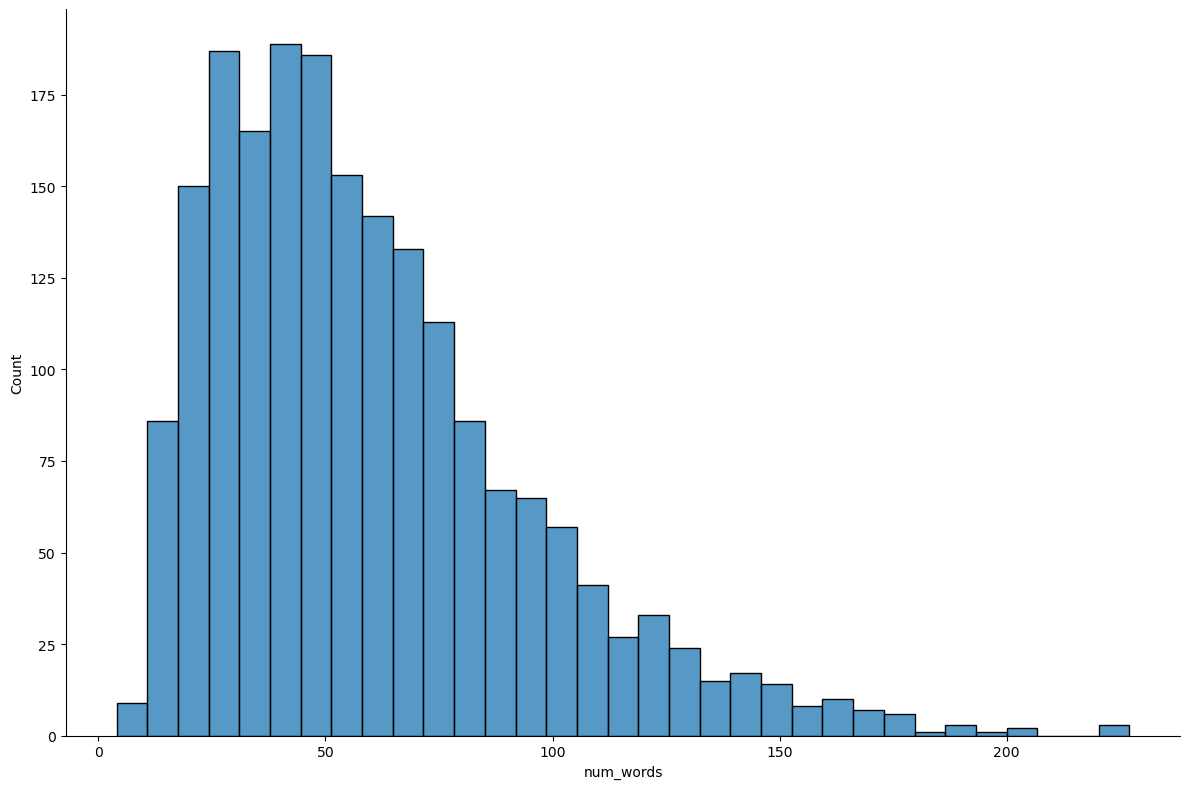

In [22]:
sns.displot(preprocessed_df.num_words,height=8,aspect=1.5)

In [23]:
max_len = 40

## Text Tokenization

In [24]:
X_train = tokenizer(text=train_data.Input.tolist(),
                   add_special_tokens=True,
                   return_tensors='tf',
                   max_length=max_len,
                   padding=True,
                   truncation=True,
                   return_token_type_ids=False,
                   return_attention_mask=True,
                   verbose=True
                   )

X_test = tokenizer(text=test_data.Input.tolist(),
                   add_special_tokens=True,
                   return_tensors='tf',
                   max_length=max_len,
                   padding=True,
                   truncation=True,
                   return_token_type_ids=False,
                   return_attention_mask=True,
                   verbose=True
                  )

## Defining the model architecture

In [34]:
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
attention_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

In [26]:
# Use the pooled_output of the BERT model as the model's output
# pooled_output = bert_model(input_ids_arr, attention_mask=attention_mask_arr)[1]  # Index 1 is the pooled_output
# model = Model(inputs=[input_ids_str, attention_mask_str], outputs=pooled_output)

In [27]:
# input_ids_tensor = Input(shape=(max_len,), name='input_ids', dtype=tf.int32)
# attention_mask_tensor = Input(shape=(max_len,), name='attention_mask', dtype=tf.int32)

# Use the input layers with the BERT model
# outputs = bert_model(input_ids_arr, attention_mask=attention_mask_arr)[0]
# output = GlobalMaxPool1D()(embeddings)
# output = Dense(units=128,activation='relu')(output)
# output = Dropout(0.1)(output)
# output = Dense(units=64,activation='relu')(output)
# output = Dense(units=32,activation='relu')(output)
# y = Dense(units=6,activation='softmax')(output)
# # Define your model
# model = Model(inputs=[input_ids, attention_mask], outputs=y)

In [28]:
# result = tf.reduce_sum(y, axis=1)

In [29]:
# output_data_float32

In [30]:
# input_ids = Input(shape=(X_train['input_ids'].shape[1],), dtype=tf.int32)
# attention_mask = Input(shape=(X_train['attention_mask'].shape[1],), dtype=tf.int32)

In [31]:
# output = Dense(units=32, activation='relu')(output)
# y = Dense(units=6, activation='softmax')(output)

In [35]:
# embeddings = bert_model(X_train['input_ids'], attention_mask=X_train['attention_mask'])[0]
# output = GlobalMaxPool1D()(embeddings)
# output = Dense(units=128,activation='relu')(output)
# output = Dropout(0.1)(output)
# output = Dense(units=64,activation='relu')(output)
# output = Dense(units=32,activation='relu')(output)
# y = Dense(units=6,activation='softmax')(output)
# outputs_placeholder = tf.keras.layers.Input(shape=(6,), dtype=tf.float32)
# output_assign = tf.keras.layers.Lambda(lambda x: outputs_placeholder)(y)
# model = Model(inputs=[input_ids,attention_mask],outputs=output_assign)
# model.layers[2].trainable = True

## Compiling the model

In [36]:
model.compile(
    loss=CategoricalCrossentropy(from_logits=True),
    optimizer=Adam(learning_rate=5e-5, epsilon=1e-8, decay=0.01, clipnorm=1.0),
    metrics=[CategoricalAccuracy(name='balanced_accuracy')]
)

## Encoding the emotion labels

In [37]:
train_data['Label'] = train_data.Sentiment.map(encoded_labels)
test_data['Label'] = test_data.Sentiment.map(encoded_labels)

In [38]:
train_data.head()

,Input,Sentiment,num_words,Label
1076,feeling disillusioned,sadness,21,4
203,fully enjoy music feel afraid using headphones,fear,46,1
410,didnt feel tragic estrangement superman family...,sadness,96,4
134,told felt better would go still feeling really...,sadness,52,4
1283,m still paying attention feel distracted,anger,40,0


In [39]:
test_data.head()

,Input,Sentiment,num_words,Label
439,feel often roll beloved new york little done s...,love,140,3
510,get pre birthday blues spend weeks feeling sli...,sadness,94,4
1574,feel grouchy one point changes panic feeling s...,anger,62,0
568,ended perfect studio walk feel aggravated bizarre,anger,49,0
260,m accused feeling superior characters usually ...,joy,73,2


## Generating the model summary and plot

In [52]:
input_ids = Input(shape=(40,), dtype='int32', name='input_ids')
attention_mask = Input(shape=(40,), dtype='int32', name='attention_mask')

In [53]:
embedding_layer = Embedding(input_dim=6, output_dim=150)(input_ids)

In [54]:
flattened = Flatten()(embedding_layer)

In [55]:
dense_layer = Dense(128, activation='relu')(flattened)
output_layer = Dense(6, activation='softmax')(dense_layer)

In [56]:
model = Model(inputs=[input_ids, attention_mask], outputs=output_layer)

In [57]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [58]:
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 40, 150)   │        900 │ input_ids[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 6000)      │          0 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 128)       │    768,128 │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 6)         │        774 │ dense_8[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 769,802 (2.94 MB)

 Trainable params: 769,802 (2.94 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
plot_model(model,'model.png',show_shapes=True,dpi=100)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


AttributeError: module 'pydot' has no attribute 'InvocationException'

## Training and fine-tuning the pretrained BERT model 

In [64]:
print(X_train['input_ids'].shape)

(1400, 40)


In [65]:
max_sequence_length = 40  # Assuming a maximum sequence length of 40
X_train_padded = np.pad(X_train['input_ids'], ((0, 0), (0, max_sequence_length - X_train['input_ids'].shape[1])), 'constant')

In [68]:
X_test_padded = np.pad(X_test['input_ids'], ((0, 0), (0, max_sequence_length - X_test['input_ids'].shape[1])), 'constant')

In [70]:
r = model.fit(
    x={'input_ids': X_train_padded, 'attention_mask': X_train['attention_mask']},
    y=to_categorical(train_data.Label),
    epochs=10,
    batch_size=32,
    validation_data=({'input_ids': X_test_padded, 'attention_mask': X_test['attention_mask']},
                     to_categorical(test_data.Label))

SyntaxError: incomplete input (3329872552.py, line 7)

In [69]:
r = model.fit(x={'input_ids': X_train['input_ids'], 'attention_mask': X_train['attention_mask']},
             y=to_categorical(train_data.Label),
             epochs=10,
             batch_size=32,
             validation_data=({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},to_categorical(test_data.Label))
             )

Epoch 1/10
35/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3457 - loss: 1.5761

ValueError: Input 1 of layer "functional_9" is incompatible with the layer: expected shape=(None, 40), found shape=(None, 39)

In [60]:
# from tensorflow.keras.layers import Input, Embedding, Flatten, Dense
# from tensorflow.keras.models import Model

# # Define input layers
# input_ids = Input(shape=(40,), dtype='int32', name='input_ids')
# attention_mask = Input(shape=(40,), dtype='int32', name='attention_mask')

# # Example: Add an embedding layer
# embedding_layer = Embedding(input_dim=6, output_dim=150)(input_ids)

# # Example: Flatten or process the embedding layer
# flattened = Flatten()(embedding_layer)

# # Example: Add more layers as needed
# dense_layer = Dense(128, activation='relu')(flattened)
# output_layer = Dense(6, activation='softmax')(dense_layer)

# # Create the model
# model = Model(inputs=[input_ids, attention_mask], outputs=output_layer)

# # Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Print the model summary
# model.summary()

In [61]:
# from tensorflow.keras.preprocessing.sequence import pad_sequences

# # Assuming X_train['input_ids'] and X_train['attention_mask'] are lists of sequences
# max_seq_length = 40  # Set the maximum sequence length

# X_train_padded = pad_sequences(X_train['input_ids'], maxlen=max_seq_length, padding='post')
# X_test_padded = pad_sequences(X_test['input_ids'], maxlen=max_seq_length, padding='post')

# # Make sure to do the same for X_train['attention_mask'] if needed

In [62]:
# input_ids = Input(shape=(max_seq_length,), dtype='int32', name='input_ids')
# attention_mask = Input(shape=(max_seq_length,), dtype='int32', name='attention_mask')

# # Modify your model to use the new input layers
# model = Model(inputs=[input_ids, attention_mask], outputs=output_assign)

## Analyzing model performance

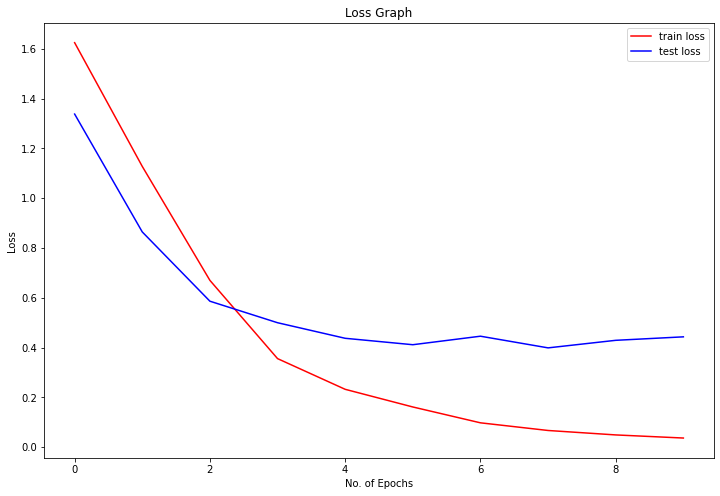

In [281]:
plt.figure(figsize=(12,8))
plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='test loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

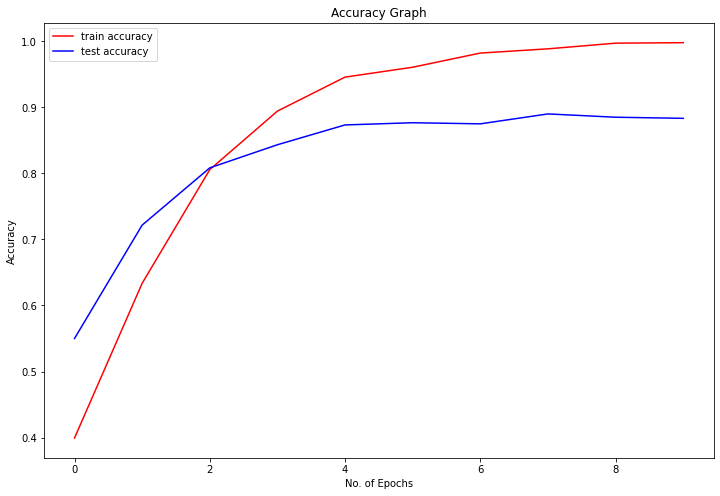

In [282]:
plt.figure(figsize=(12,8))
plt.plot(r.history['balanced_accuracy'],'r',label='train accuracy')
plt.plot(r.history['val_balanced_accuracy'],'b',label='test accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

## Saving the model

In [284]:
model.save("emotion_detector.h5")

## Evaluating the model on the test dataset

In [285]:
loss, acc = model.evaluate({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},to_categorical(test_data.Label))
print("Test Categorical Cross-Entropy Loss:",loss)
print("Test Categorical Accuracy:",acc)

19/19 [==============================] - 5s 91ms/step - loss: 1.1729 - balanced_accuracy: 0.8833
Test Categorical Cross-Entropy Loss: 1.1729487180709839
Test Categorical Accuracy: 0.8833333253860474


In [286]:
test_predictions = model.predict({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']})
test_predictions = np.argmax(test_predictions,axis=1)
print(classification_report(test_data.Label,test_predictions))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89        77
           1       0.82      0.85      0.83        68
           2       0.93      0.89      0.91       209
           3       0.69      0.81      0.75        54
           4       0.92      0.92      0.92       173
           5       0.88      0.74      0.80        19

    accuracy                           0.88       600
   macro avg       0.85      0.85      0.85       600
weighted avg       0.89      0.88      0.88       600



The result is quite promising as we've obtained an excellent f1-score of almost 80% for all the 6 emotion classes.